# Procedure for image preprocessing

## Setup

In [86]:
# %load_ext nb_black
# %matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import cv2
from PIL import ImageStat
import random
import os
from dotenv import load_dotenv

In [87]:
load_dotenv()
os.environ.get("TRAINING_DIRECTORY")

'C:/Users/nikla/Documents/Semester6/data/cucumber-dataset-compressed/normal-light'

## Define constants and read the data

In [88]:
# Set the path to the folders containing the images
# train_dir = './training_data/'
train_dir = os.environ.get("TRAINING_DIRECTORY")

# Define the image size
img_height = 1024
img_width = 1024

# Define the batch size
batch_size = 32

In [89]:
# Read in the images and resize them
classes = ["healthy", "infected"]
images = []
labels = []
img_paths = []
img_dir = f"{train_dir}/mini-healthy"
for img_file in os.listdir(img_dir):
    path = os.path.join(img_dir, img_file)
    img = tf.keras.preprocessing.image.load_img(
        path, target_size=(img_height, img_width)
    )
    img = tf.keras.preprocessing.image.img_to_array(img, dtype=np.uint8)
    images.append(img)
    labels.append(0)
    img_paths.append(path)

img_dir = f"{train_dir}/mini-infected"
for img_file in os.listdir(img_dir):
    path = os.path.join(img_dir, img_file)
    img = tf.keras.preprocessing.image.load_img(
        path, target_size=(img_height, img_width)
    )
    img = tf.keras.preprocessing.image.img_to_array(img, dtype=np.uint8)
    images.append(img)
    labels.append(1)
    img_paths.append(path)

# Convert the data and labels to NumPy arrays
images = np.array(images)
labels = np.array(labels)
img_paths = np.array(img_paths)

In [90]:
images.shape

(300, 1024, 1024, 3)

## Store some information about the dataset into a Dataframe

- The cucumber image is masked (where the BLUE channel is below some threshold to filter out the background)
- The first row is found where the mask contains at least 1/64 true values (sorting out possible single pixels that were not filtered out)
    - This is considered the start y-pixel-coordinate of the cucumber
- From there search the first row where there are less than 1/64 true values
    - This is considered the end y-pixel-coordinate of the cucumber 
- Same process is repeated for columns to get the x-pixel-coordinates


Shape: (300, 1048576)


(array([4.43130e+04, 1.49390e+04, 9.41300e+03, 6.65900e+03, 5.52400e+03,
        4.76000e+03, 4.12500e+03, 3.79400e+03, 3.31800e+03, 3.09400e+03,
        3.02200e+03, 2.67100e+03, 2.73600e+03, 2.60000e+03, 2.49600e+03,
        2.35800e+03, 2.14200e+03, 1.84000e+03, 1.61300e+03, 1.28100e+03,
        1.11400e+03, 8.84000e+02, 7.73000e+02, 6.63000e+02, 5.68000e+02,
        4.54000e+02, 3.84000e+02, 3.06000e+02, 3.05000e+02, 2.46000e+02,
        2.28000e+02, 2.04000e+02, 1.86000e+02, 1.72000e+02, 1.93000e+02,
        2.03000e+02, 2.53000e+02, 3.08000e+02, 4.80000e+02, 1.13100e+03,
        2.54200e+03, 4.98900e+03, 7.99900e+03, 1.11950e+04, 1.59890e+04,
        2.66260e+04, 5.72790e+04, 1.10072e+05, 1.66219e+05, 2.06605e+05,
        3.07308e+05]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105.,
        110., 115., 120., 125., 130., 135., 140., 145., 150., 155., 160.,
        165., 170., 175.,

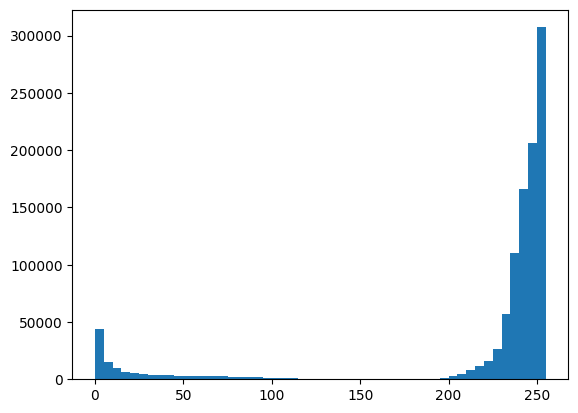

In [91]:
# Map all images to their blue channel and flatten them
images_blue_flattened = []
for image in images:
    images_blue_flattened.append(images[0][:, :, 2].ravel())
images_blue_flattened = np.array(images_blue_flattened)
print(f'Shape: {images_blue_flattened.shape}')
# Plot the average number of blue pixels per image
# mean = images_blue_flattened.mean(axis=0)
mean = np.median(images_blue_flattened, axis=0)
plt.hist(mean, bins=int(255/5))

# Use the histogram to find the threshold for masking the background

In [92]:
# Get the first y-pixel value where at least 1/64 of the pixels are masked
MASK_BLUE_THRESHOLD = 130


def get_first_and_last_cucumber_pixel(image):
    # masked_img = image[..., 2] < MASK_BLUE_THRESHOLD

    (_, masked_img) = cv2.threshold(
        image[..., 2], MASK_BLUE_THRESHOLD, 1, cv2.THRESH_BINARY_INV)

    first_cucumber_pixel_y = None
    last_cucumber_pixel_y = None
    threshold = img_width / 64
    for i in range(masked_img.shape[0]):
        if np.sum(masked_img[i, :]) > threshold:
            first_cucumber_pixel_y = i
            j = first_cucumber_pixel_y
            for j in range(i, masked_img.shape[0]):
                if np.sum(masked_img[j, :]) <= threshold:
                    last_cucumber_pixel_y = j
                    break
            break

    first_cucumber_pixel_x = None
    last_cucumber_pixel_x = None
    threshold = 2
    for i in range(masked_img.shape[1]):
        if np.sum(masked_img[:, i]) > threshold:
            first_cucumber_pixel_x = i
            j = first_cucumber_pixel_x
            for j in range(i, masked_img.shape[0]):
                if np.sum(masked_img[:, j]) <= threshold:
                    last_cucumber_pixel_x = j
                    break
            break

    return (
        (first_cucumber_pixel_x, first_cucumber_pixel_y),
        (last_cucumber_pixel_x, last_cucumber_pixel_y),
    )

In [93]:
# Create the DataFrame

df_records = []
for i in range(images.shape[0]):
    ((first_x, first_y), (last_x, last_y)) = get_first_and_last_cucumber_pixel(
        images[i]
    )
    df_records.append(
        {
            "idx": i,
            "label": classes[labels[i]],
            "first_cucumber_pixel_y": first_y,
            "last_cucumber_pixel_y": last_y,
            "first_cucumber_pixel_x": first_x,
            "last_cucumber_pixel_x": last_x,
            "cucumber_height": last_y - first_y,
            "cucumber_width": last_x - first_x,
        }
    )

df = pd.DataFrame(df_records)

print(df)

     idx     label  first_cucumber_pixel_y  last_cucumber_pixel_y  \
0      0   healthy                     333                    572   
1      1   healthy                     331                    565   
2      2   healthy                     327                    609   
3      3   healthy                     352                    570   
4      4   healthy                     324                    558   
..   ...       ...                     ...                    ...   
295  295  infected                     311                    643   
296  296  infected                     311                    558   
297  297  infected                     332                    581   
298  298  infected                     311                    581   
299  299  infected                     349                    636   

     first_cucumber_pixel_x  last_cucumber_pixel_x  cucumber_height  \
0                       163                    848              239   
1                       151  

## Plot some random images from the dataset with their label and a box around the cucumber using the detected cucumber pixels calculated in the above Dataframe

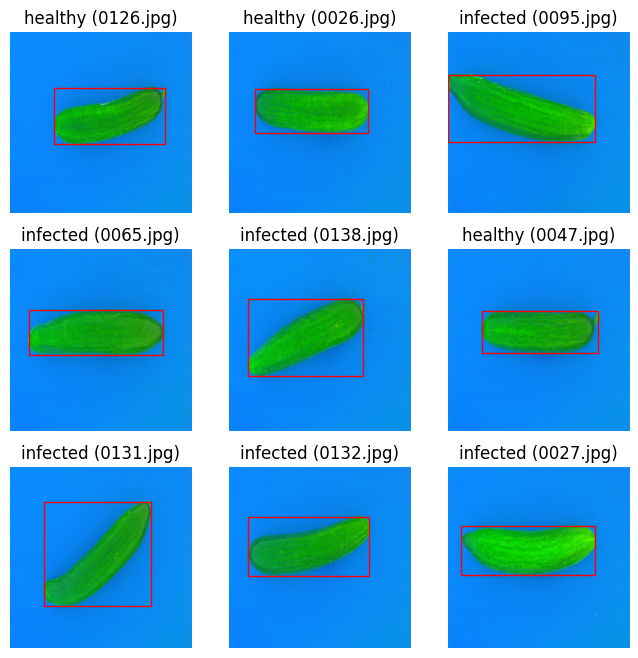

In [94]:
def plot_cucumbers_with_boxes(images, df, classes, labels, img_paths):
    # Plot some random images with their label and a line for the first "cucumber pixel" detected
    plt.figure(figsize=(8, 8))
    # rand = random.randint(0, images.shape[0] - 10)
    for i in range(9):
        rand_idx = random.randint(0, images.shape[0] - 1)
        # rand_idx = rand + i
        # rand_idx = 25 + i
        ax = plt.subplot(3, 3, i + 1)
        rect = patches.Rectangle(
            (
                df.iloc[rand_idx]["first_cucumber_pixel_x"],
                df.iloc[rand_idx]["first_cucumber_pixel_y"],
            ),
            df.iloc[rand_idx]["last_cucumber_pixel_x"]
            - df.iloc[rand_idx]["first_cucumber_pixel_x"],
            df.iloc[rand_idx]["last_cucumber_pixel_y"]
            - df.iloc[rand_idx]["first_cucumber_pixel_y"],
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )

        ax.add_patch(rect)
        plt.imshow(images[rand_idx])
        path = img_paths[rand_idx].split(os.sep)[-1]
        plt.title(f"{classes[labels[rand_idx]]} ({path})")
        plt.axis("off")


plot_cucumbers_with_boxes(images, df, classes, labels, img_paths)


In [95]:
def remove_image_background(image):
    (_, masked_img) = cv2.threshold(
        image[..., 2], MASK_BLUE_THRESHOLD, 1, cv2.THRESH_BINARY_INV)
    # masked_img = image[..., 2] < MASK_BLUE_THRESHOLD

    img_mask_reshaped = np.zeros((*masked_img.shape, 3))
    img_mask_reshaped[np.where(masked_img)] = [1, 1, 1]

    return np.multiply(image, img_mask_reshaped).astype(np.uint8)

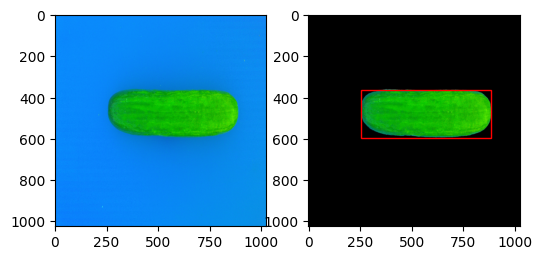

In [96]:
def plot_cucumber_without_bg(images, df):
    idx = random.randint(0, images.shape[0] - 1)
    image = images[idx]

    plt.figure(figsize=(6, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    ax = plt.subplot(1, 2, 2)
    rect = patches.Rectangle(
        (df.iloc[idx]["first_cucumber_pixel_x"], df.iloc[idx]["first_cucumber_pixel_y"]),
        df.iloc[idx]["last_cucumber_pixel_x"] - df.iloc[idx]["first_cucumber_pixel_x"],
        df.iloc[idx]["last_cucumber_pixel_y"] - df.iloc[idx]["first_cucumber_pixel_y"],
        linewidth=1,
        edgecolor="r",
        facecolor="none",
    )

    ax.add_patch(rect)
    plt.imshow(remove_image_background(image))
    plt.show()


plot_cucumber_without_bg(images, df)


In [97]:
print(f'Images infected: {(len(df[df["label"]=="infected"]))}')
print(f'Images healthy: {(len(df[df["label"]=="healthy"]))}')

Images infected: 144
Images healthy: 156


In [98]:
df_sorted_by_height = df.sort_values("cucumber_height", ascending=False)
img_paths[df_sorted_by_height["idx"][:10]]

array(['C:/Users/nikla/Documents/Semester6/data/cucumber-dataset-compressed/normal-light/mini-infected\\0123.jpg',
       'C:/Users/nikla/Documents/Semester6/data/cucumber-dataset-compressed/normal-light/mini-infected\\0127.jpg',
       'C:/Users/nikla/Documents/Semester6/data/cucumber-dataset-compressed/normal-light/mini-infected\\0131.jpg',
       'C:/Users/nikla/Documents/Semester6/data/cucumber-dataset-compressed/normal-light/mini-infected\\0120.jpg',
       'C:/Users/nikla/Documents/Semester6/data/cucumber-dataset-compressed/normal-light/mini-healthy\\0132.jpg',
       'C:/Users/nikla/Documents/Semester6/data/cucumber-dataset-compressed/normal-light/mini-infected\\0136.jpg',
       'C:/Users/nikla/Documents/Semester6/data/cucumber-dataset-compressed/normal-light/mini-healthy\\0143.jpg',
       'C:/Users/nikla/Documents/Semester6/data/cucumber-dataset-compressed/normal-light/mini-healthy\\0133.jpg',
       'C:/Users/nikla/Documents/Semester6/data/cucumber-dataset-compressed/normal-

In [99]:
img_paths[df[df["first_cucumber_pixel_y"] < 4]["idx"]]

array([], dtype='<U103')

In [100]:
img_paths[df[df["last_cucumber_pixel_y"] > img_height - 4]["idx"]]

array([], dtype='<U103')

In [101]:
# idx = random.randint(0, images.shape[0] - 1)
# image = images[idx]

# # Remove background
# masked_img = image[..., 2] < MASK_BLUE_THRESHOLD
# img_mask_reshaped = np.zeros((*masked_img.shape, 3))
# img_mask_reshaped[np.where(masked_img)] = [1, 1, 1]

# image = np.multiply(image, img_mask_reshaped).astype(np.uint8)

# plt.figure(figsize=(6, 6))
# plt.imshow(image)


In [102]:
idx = random.randint(0, images.shape[0] - 1)
image = remove_image_background(images[idx])
df_entry = df.iloc[idx]

def crop_both_cucumber_tips(image, df_entry):
    total_height = df_entry["cucumber_height"]
    total_width = df_entry["cucumber_width"]

    if total_height > total_width:
        raise ValueError("Cucumber height is bigger than width")

    # Crop images to both tips
    img_left = image[
        df_entry["first_cucumber_pixel_y"] : df_entry["last_cucumber_pixel_y"],
        df_entry["first_cucumber_pixel_x"] : df_entry["first_cucumber_pixel_x"]
        + total_height,
    ]

    img_right = image[
        df_entry["first_cucumber_pixel_y"] : df_entry["last_cucumber_pixel_y"],
        df_entry["last_cucumber_pixel_x"]
        - total_height : df_entry["last_cucumber_pixel_x"],
    ]

    img_left = cv2.resize(src=img_left, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)

    img_right = cv2.resize(src=img_right, dsize=(
        224, 224), interpolation=cv2.INTER_CUBIC)
    
    return (img_left, img_right)


img_left, img_right = crop_both_cucumber_tips(image, df_entry)

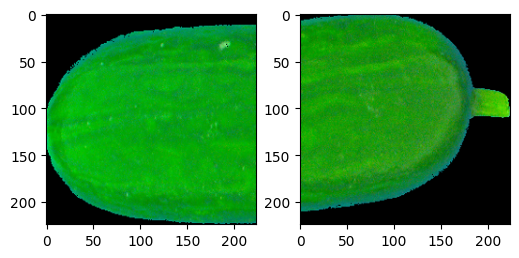

In [103]:
plt.figure(figsize=(6, 6))
plt.subplot(2, 2, 1)
plt.imshow(img_left, cmap=plt.get_cmap("gray"))
plt.subplot(2, 2, 2)
plt.imshow(img_right, cmap=plt.get_cmap("gray"))

plt.show()

(224, 224, 3)
(224, 224, 3)


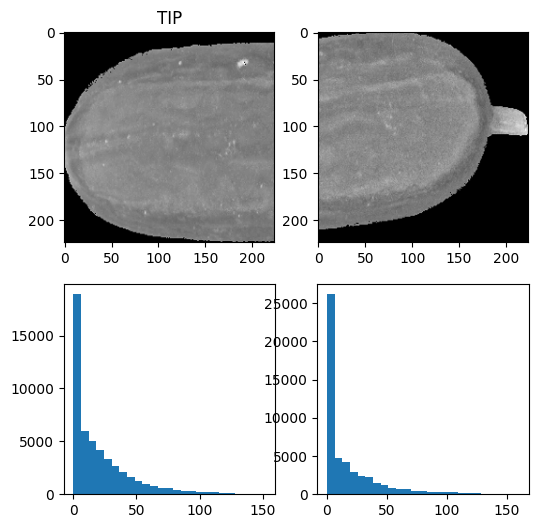

In [104]:
print(img_left.shape)
print(img_right.shape)

img_left_grey = np.dot(img_left[..., :], [0.2989, 0.5870, 0.1140])
img_right_grey = np.dot(img_right[..., :], [0.2989, 0.5870, 0.1140])

mean_brightness_left = np.mean(img_left_grey, axis=None)
mean_brightness_right = np.mean(img_right_grey, axis=None)

plt.figure(figsize=(6, 6))
plt.subplot(2, 2, 1)
plt.imshow(img_left_grey, cmap=plt.get_cmap("gray"))
if mean_brightness_left > mean_brightness_right:
    plt.title("TIP")

plt.subplot(2, 2, 2)
plt.imshow(img_right_grey, cmap=plt.get_cmap("gray"))
if mean_brightness_right > mean_brightness_left:
    plt.title("TIP")

plt.subplot(2, 2, 3)
plt.hist(img_left[..., 2].ravel(), bins=25)

plt.subplot(2, 2, 4)
plt.hist((img_right[..., 2].ravel()), bins=25)


plt.show()